In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import pandas_datareader.data as web
import scipy.optimize as opt

In [2]:
data = pd.DataFrame() #빈 dataframe 생성
for code in ['005930', '000660', '035720', '035420'] :  #data 불러오기(4가지 주식종목에 대한 19.01.01~20.01.01)
    data = pd.concat([data,web.DataReader(code, 'naver', start='2019-01-01', end='2020-01-01')['Close'].apply(int)], axis=1)

noa = len(data.columns) #noa 변수에 column개수 할당

In [3]:
# get returns
ret = data.pct_change().dropna()  #data를 직전 거래일대비 수익률로 정리해서 ret에 할당(NAN은 drop)

In [4]:
port_rets = [] #포트폴리오 수익률을 모으기 위해 빈리스트 생성 
port_std = [] #포트폴리오의 mean, std을 모으기 위한 빈리스트 생성

def ret_std(weight, ret): #포트폴리오의 비중과 수익률을 넣으면 포트폴리오 mean, std를 반환하는 함수 선언
    port_mean = np.sum(weight * ret.mean() *250) #포트폴리오 수익률의 평균구하기
    port_var = np.dot(weight.T, np.dot(ret.cov()*250, weight)) #포트폴리오 수익률의 분산구하기
    port_std = np.sqrt(port_var) #분산에 루트를 취해 표준편차 구한 모습
    return port_mean, port_std #평균 표준편차 반환

for w in range(2500): #2500개의 포트폴리오를 구성하기 위한 루프
    weight = np.random.random(noa) #종목개수만큼 랜덤한 숫자를 부여함.(랜덤하게 비중 부여하는 작업)
    weight /= np.sum(weight) #개별종목비중을 (랜덤한 숫자/그 숫자들의 합)으로 나타내어 비율로써 부여
    mu, sig = ret_std(weight, ret) #위의 함수로 수익률의 평균과 표준편차 반환
    port_rets.append(mu) #아까 생성한 ret 리스트에 수익률 평균 append
    port_std.append(sig) #아까 생성한 std 리스트에 수익률 표준편차 append

sr = np.array(port_rets)/np.array(port_std) #sharpe ratio 생성

In [5]:
def statistics(weights, rf=0): #weight와 rf를 인수로 가지는 함수 statistics 선언(포트폴리오 수익률, volatility, sharpe ratio반환)
    ''' Return portfolio statistics.
    
    Parameters
    ==========
    weights : array-like
        weights for different securities in portfolio
    
    Returns
    =======
    pret : float
        expected portfolio return
    pvol : float
        expected portfolio volatility
    pret / pvol : float
        Sharpe ratio for rf=0
    '''
    weights = np.array(weights) #weight를 array변환
    pret = np.sum(ret.mean() * weights) * 252 - rf  #포트폴리오 수익률 생성
    pvol = np.sqrt(np.dot(weights.T, np.dot(ret.cov() * 252, weights))) #포트폴리오 volatility 생성
    return np.array([pret, pvol, pret / pvol])  #포트폴리오 수익률, volatility, sharpe ratio반환

def min_func_sharpe(weights, rf=0): #sharpe ratio 반환하는 함수
    return -statistics(weights, rf)[2]#sharpe ratio 반환

def min_func_volatility(weights): #volatility 반환하는 함수
    return statistics(weights)[1] **2  #volatility 반환

#다음은 최적화 함수에 들어가는 argument들을 모아놓은 것임
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa)) # ((0, 1), (0, 1), (0, 1), (0, 1))
noa * [1. / noa,]  # [0.25, 0.25, 0.25, 0.25]

#다음은 sharpe ratio를 최적화하는 작업임
opts = opt.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
#다음은 volatility를 최적화하는 작업임
optv = opt.minimize(min_func_volatility, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

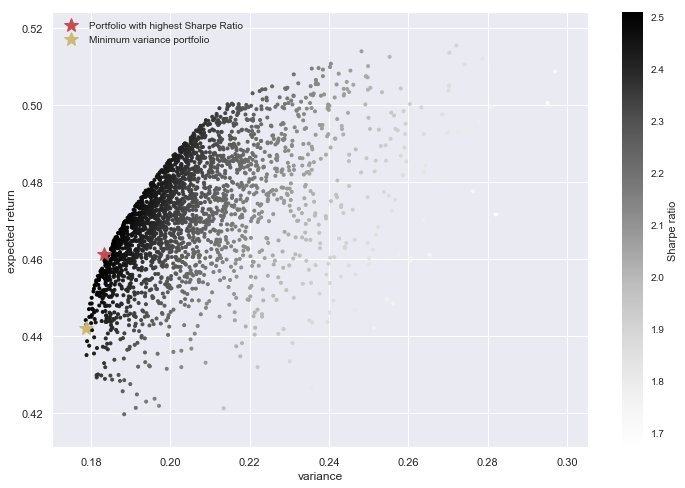

In [6]:
plt.figure(figsize=(12, 8))  #그림 사이즈 가로 12 세로8
plt.scatter(port_std, port_rets, #x축에 포트폴리오 표준편차, y축에 평균 수익률을 점(.)으로 표시
            c=np.array(port_rets) / np.array(port_std), marker='.', cmap = 'Greys')#  sr을 좌측에 하양,회색의 cmap으로 표시
            # random portfolio composition
    
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0], #sharpe ratio가 가장 높은 port를 빨간 별로 표시(marker size = 15)
         'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio') #라벨링 'Portfolio with highest Sharpe Ratio'
            # portfolio with highest Sharpe ratio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],#variance가 가장 낮은 port를 노란 별로 표시(marker size = 15)
         'y*', markersize=15.0, label = 'Minimum variance portfolio') #라벨링 'Minimum variance portfolio'
            # minimum variance portfolio

plt.style.use('seaborn') #seaborn style사용
plt.legend() #우측상단에 범례 출력
plt.grid(True) # 격자 생성
plt.xlabel('variance') #x축에 라벨링 'variance'  
plt.ylabel('expected return')  #y축에 라벨링 'expected return' 
plt.colorbar(label='Sharpe ratio') #colorbar에 라벨링 'Sharpe ratio'  

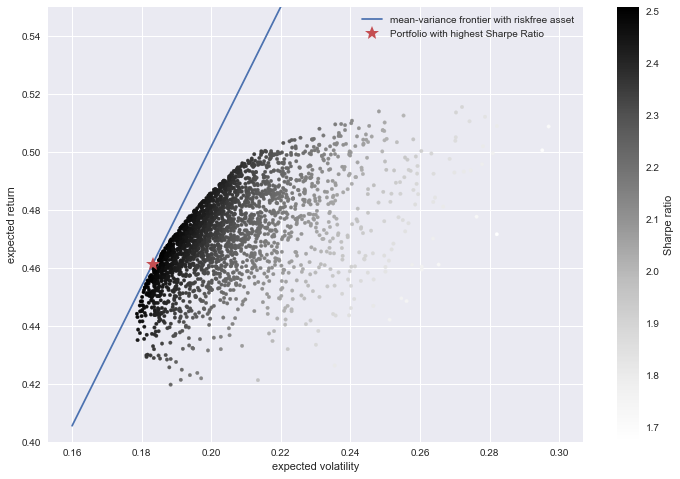

In [7]:
rf = 0.02  #risk free asset 수익률 0.02할당
slope = (statistics(opts['x'])[0] - rf) / statistics(opts['x'])[1] #mean variance frontier의 기울기 구하기
x =  np.linspace(0.16,0.30,2500) #0.16부터 0.30까지 일정간격으로 2500개 x 생성
y = [x*slope + rf for x in np.linspace(0.16,0.30,2500)]#mean variance frontier의 y값들 설정(x에 기울기 곱하고 rf더한 값들)

plt.figure(figsize=(12, 8))  #그림 사이즈 가로 12 세로8
plt.scatter(port_std, port_rets,  #x축에 포트폴리오 표준편차, y축에 평균 수익률을 점(.)으로 표시
            c=np.array(port_rets) / np.array(port_std), marker='.',cmap = 'Greys') #  sr을 좌측에 하양,회색의 cmap으로 표시  

plt.plot(x,y, label = 'mean-variance frontier with riskfree asset') #mean variance frontier를 그린다. 라벨링은 'mean-variance frontier with riskfree asset'
            # random portfolio composition  
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],#sharpe ratio가 가장 높은 port를 빨간 별로 표시(marker size = 15)
         'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio')#라벨링 'Portfolio with highest Sharpe Ratio'
            # portfolio with highest Sharpe ratio
    
plt.ylim((0.4, 0.55)) #y축범위 0.4~0.55
plt.legend() #우측상단에 범례 출력
plt.grid(True) # 격자 생성
plt.xlabel('expected volatility')#x축에 라벨링 'expected volatility'     
plt.ylabel('expected return') #y축에 라벨링 'expected return'      
plt.colorbar(label='Sharpe ratio') #colorbar에 라벨링 'Sharpe ratio'                  